##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Probabilistic Matrix Factorization with TFP

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/probabilistic_matrix_factorization_with_tfp.ipynb"><img height="32px" src="https://colab.research.google.com/img/colab_favicon.ico" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/probabilistic_matrix_factorization_with_tfp.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>
<br>
<br>
<br>

Original content [this Repository](https://github.com/blei-lab/edward/blob/master/examples/probabilistic_matrix_factorization.py), created by [the Blei Lab](http://www.cs.columbia.edu/~blei/)

Ported to [Tensorflow Probability](https://www.tensorflow.org/probability/) by Matthew McAteer ([`@MatthewMcAteer0`](https://twitter.com/MatthewMcAteer0)), with help from Bryan Seybold, Mike Shwe ([`@mikeshwe`](https://twitter.com/mikeshwe)), Josh Dillon, and the rest of the TFP team at  Google ([`tfprobability@tensorflow.org`](mailto:tfprobability@tensorflow.org)).

---

- Dependencies & Prerequisites
- Introduction
  - True Latent Factors
  - Data
  - Model
  - Inference
  - Criticism
- References

## Dependencies & Prerequisites

<div class="alert alert-success">
    Tensorflow Probability is part of the colab default runtime, <b>so you don't need to install Tensorflow or Tensorflow Probability if you're running this in the colab</b>. 
    <br>
    If you're running this notebook in Jupyter on your own machine (and you have already installed Tensorflow), you can use the following
    <br>
      <ul>
    <li> For the most recent nightly installation: <code>pip3 install -q tfp-nightly</code></li>
    <li> For the most recent stable TFP release: <code>pip3 install -q --upgrade tensorflow-probability</code></li>
    <li> For the most recent stable GPU-connected version of TFP: <code>pip3 install -q --upgrade tensorflow-probability-gpu</code></li>
    <li> For the most recent nightly GPU-connected version of TFP: <code>pip3 install -q tfp-nightly-gpu</code></li>
    </ul>
Again, if you are running this in a Colab, Tensorflow and TFP are already installed
</div>

In [0]:
#@title Imports and Global Variables  { display-mode: "form" }
from __future__ import absolute_import, division, print_function

#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import string
from datetime import datetime
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
tfe = tf.contrib.eager

# Eager Execution
#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = False #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
    try:
        tf.enable_eager_execution()
    except:
        pass

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow_probability import edward2 as ed
from tensorflow.python.ops import control_flow_ops

  
def evaluate(tensors):
  """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
  Args:
  tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
    `namedtuple` or combinations thereof.
 
  Returns:
    ndarrays: Object with same structure as `tensors` except with `Tensor` or
      `EagerTensor`s replaced by Numpy `ndarray`s.
  """
  if tf.executing_eagerly():
    return tf.contrib.framework.nest.pack_sequence_as(
        tensors,
        [t.numpy() if tf.contrib.framework.is_tensor(t) else t
         for t in tf.contrib.framework.nest.flatten(tensors)])
  return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=True):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options()
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()

## Introduction

In this notebook, we show you how to use Probabilistic matrix factorization using variational inference [[1]](#scrollTo=HaxsCOwVRs4i).

Specifically, this visualizes the actual and the estimated rating matrices as heatmaps [[2]](#scrollTo=HaxsCOwVRs4i).

In [0]:
#@title ## Model Parameters
# Set seed. Remove this line to generate different mixtures!
tf.set_random_seed(77)

#@markdown ### Number of Users
#@markdown N is an integer representing the number of users (Default is 50).
N = 50 #@param {type:"number"}
#@markdown ### Number of Movies
#@markdown M is an integer representing the number of users (Default is 60).
M = 60         #@param {type:"number"}
#@markdown ### Number of Latent Factors
#@markdown D is an integer representing the number of latent factors in our model (Default is 3).
D = 3  #@param {type:"number"} Number of latent factors

# Creating our synthetic data
U_true = evaluate(tfd.Normal(loc=0., scale=1.).sample(sample_shape=[D, N]))
V_true = evaluate(tfd.Normal(loc=0., scale=1.).sample(sample_shape=[D, M]))
print("Shape of our matrix of users and latent factors (U_true):", U_true.shape)
print("Shape of our matrix of videos and latent factors (V_true):", V_true.shape)

Shape of our matrix of users and latent factors (U_true): (3, 50)
Shape of our matrix of videos and latent factors (V_true): (3, 60)


## Data

Here, we're creating our Training and Test Data. our `build_toy_dataset` function takes in the matrix of the $\text{Users} \times \text{latent dimensions}$, the $\text{Videos} \times \text{latent dimensions}$, the numbers of users and videos, and a parameter for noise (it's a toy dataset, but we'd at least like to add _some_ unpredictability to it). This returns Our $N \times M$ matrix of our users and their movies of choice.

<img src="https://camo.githubusercontent.com/ddd2be377ea2598056c581fb4d4b152da6ae1970/68747470733a2f2f63646e2d696d616765732d312e6d656469756d2e636f6d2f6d61782f313736302f312a32692d474a4f374a5830597a363439386a55766845672e706e67" alt="Girl in a jacket" width="600">

Shape of R_true: 
 (50, 60)


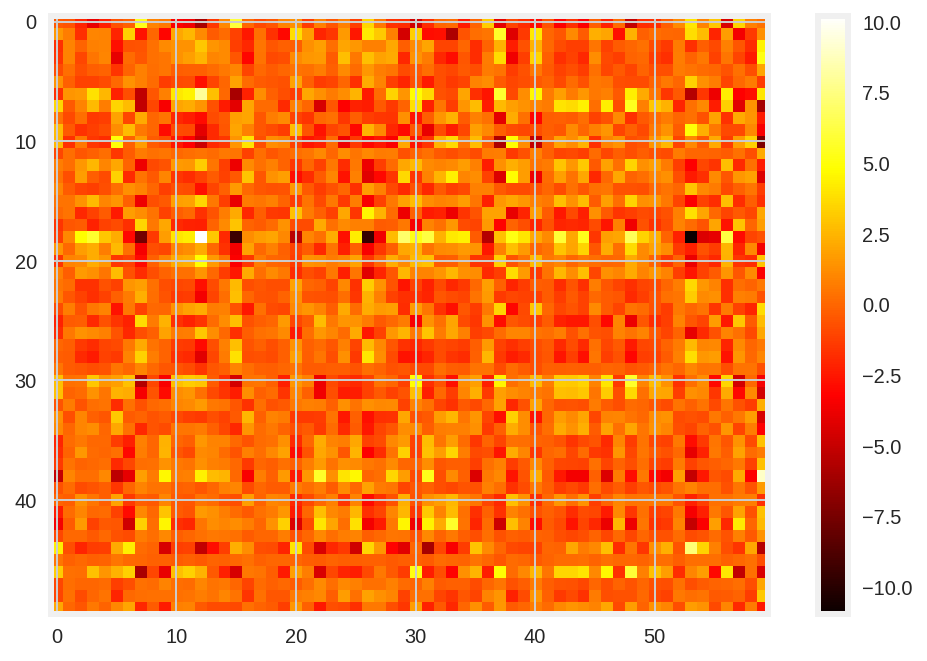

In [0]:
def build_toy_dataset(U, V, N, M, noise_std=0.1):
    """
    Function for building our toy dataset.
        
    Args:
      U: Integer
      V: Integer
      N: Integer Number of Users
      M: Integer Number of Movies
      noise_std: a float used for determining the standard deviation of our Normal
        sampling distribution. The SD is effetively equivalent to the amount of noise.
    Returns: 
      np.array-like dataframe representing our data of choice for users and their
        movies of choice.
    """  
    #R = np.dot(np.transpose(U), V) + np.random.normal(0, noise_std, size=(N, M))
    R = tf.tensordot(tf.transpose(U), V, axes=1) + tfd.Normal(0, noise_std).sample(sample_shape=(N, M))
    return R

R_true = evaluate(build_toy_dataset(U_true, V_true, N, M))
print("Shape of R_true: \n", R_true.shape)
plt.imshow(R_true, cmap='hot')
plt.colorbar()
plt.show()

Of course we're not just listing movies. As far as the data we've provided goes, there's no difference between 'Boyhood' and 'Before Sunset' aside from the identifying strings (we haven't added any sting identifiers to our Dataframe, so there isn't even that, just matrix indecies). We need to provide some features to distinguish these movies. For example, if there were an actual video set, we might use a boolean to denote features such as whether there's a Villain in the story, whether the movie was made by Pixar, whether the movie can be classified as a Korean Action Comedy, etc.. We can easily simulate some indicators $I_\text{train}, I_\text{test}$ for this matrix with our `get_indicators` function, which gets an $N \times M$ sample from a binomial distribution.

Shape of Training data for the indicators (I_train):  (50, 60)
Shape of Test data for the indicators (I_test):  (50, 60)


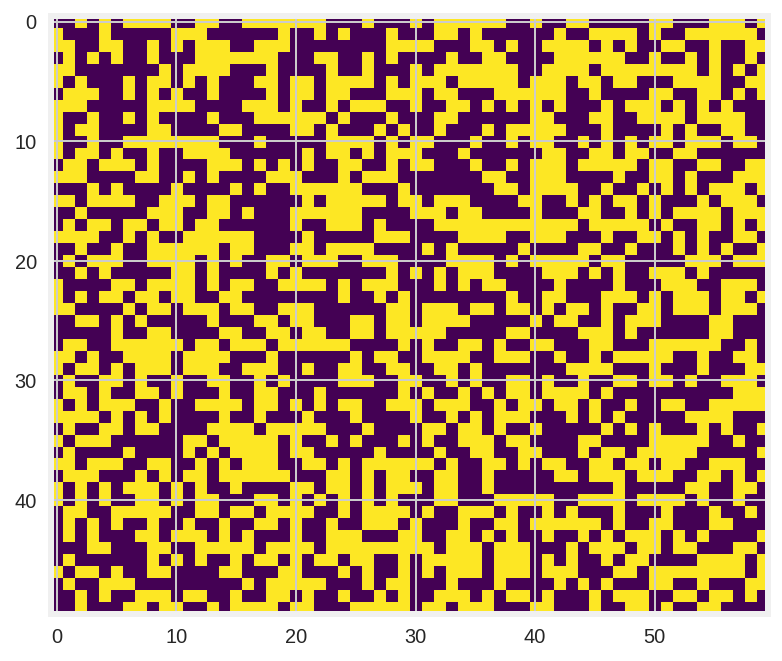

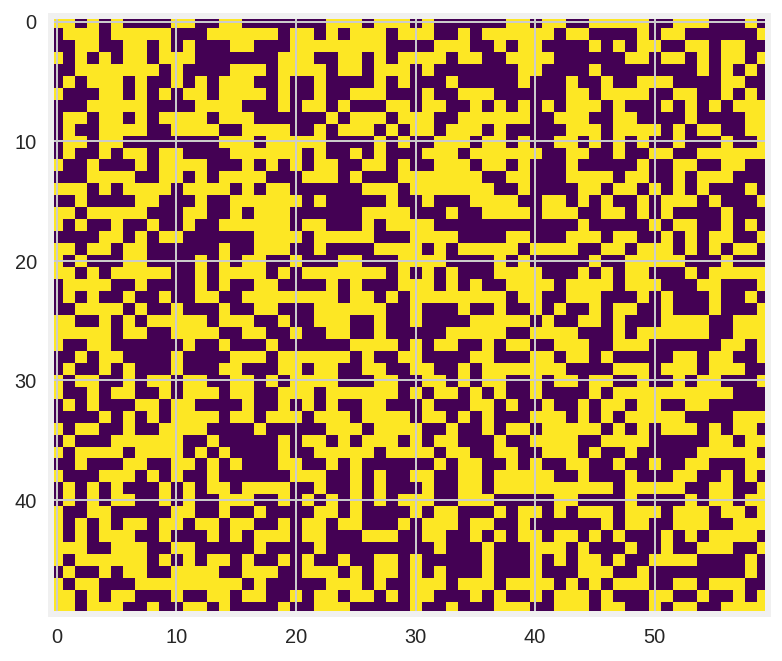

In [0]:
def get_indicators(N, M, prob_std=0.5):
    """
    Function for building our toy dataset.
        
    Args:
      N: Integer Number of Users
      M: Integer Number of Movies
      prob_std: a float used for determining the standard deviation of our 
        probabilities in our Binomial sampling distribution. The SD is 
        effetively equivalent to the amount of noise in our sampling 
        distribution.
    Returns: 
      np.array-like dataframe representing our indicators for predicting 
        users' movie choices.
    """    
    ind = np.random.binomial(1, prob_std, (N, M))
    return ind

I_train = get_indicators(N, M)
I_test = 1 - I_train

print("Shape of Training data for the indicators (I_train): ", I_train.shape)
print("Shape of Test data for the indicators (I_test): ", I_test.shape)
plt.imshow(I_train, cmap='viridis')
plt.show()
plt.imshow(I_test, cmap='viridis')
plt.show()

## Model

For our model, we're setting up 3 distribtutions. Each of these distributions is going to be factored into our log likelihood function later on, though we're also going to be using each of these indificually for calculating the Kullback–Leibler divergence (i.e., a measure of how different one probability distribution is from a second). Our distributions for $U$ and $V$ are relatively simple. These are similar to the $U$ and $V$ distributions that we originally got our mock data from. We will also multiply these by our $I$ indicator matrix of boolean values. The idea is that this indicator would be for whether or not the video was watched by a particular user. 

We define our distributions below, and then provide an example of what a given user might have chosen for their reviews based on this model.


I (indicators): 
 (50, 60)

Distribution for `U` (users): 
 tfp.distributions.Normal("Normal_3/", batch_shape=(3, 50), event_shape=(), dtype=float32)

Distribution for `V` (videos): 
 tfp.distributions.Normal("Normal_4/", batch_shape=(3, 60), event_shape=(), dtype=float32)

Distribution for `R` (review): 
 tfp.distributions.Normal("Normal_5/", batch_shape=(50, 60), event_shape=(), dtype=float32)


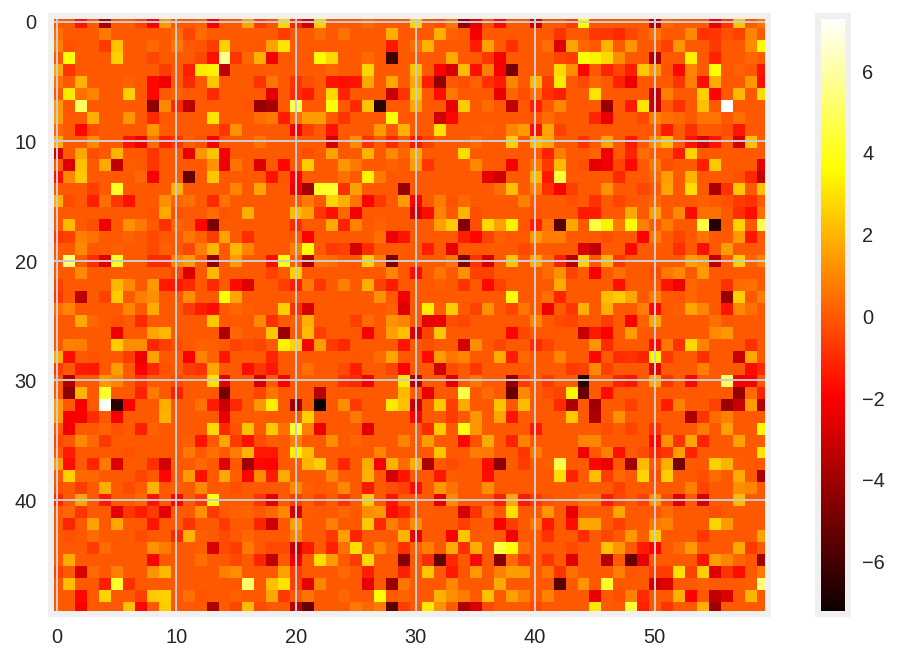

In [0]:
#I = tf.placeholder(tf.float32, [N, M])
I = I_train
rv_U = tfd.Normal(loc=tf.fill([D, N], 0.0), scale=tf.fill([D, N], 1.0)) # Distribution
rv_V = tfd.Normal(loc=tf.fill([D, M], 0.0), scale=tf.fill([D, M], 1.0)) # Distribution
rv_R = tfd.Normal(loc=tf.matmul(tf.transpose(rv_U.sample()), rv_V.sample()) * I,
               scale=tf.ones([N, M]) * I)

print("I (indicators): \n", I.shape)
print("\nDistribution for `U` (users): \n", rv_U)
print("\nDistribution for `V` (videos): \n", rv_V)
print("\nDistribution for `R` (review): \n", rv_R)

plt.imshow(evaluate(rv_R.sample()), cmap='hot')
plt.colorbar()
plt.show()

As we can see, we have a lot of reviews for these movies, but a lot of them are missing or blank.  Not every user may have watched and rated every video. That's why we turn to probabilistic matrix factorization. We're looking to create a model of how each user would rate every video if they watched them.

This was also why for the test dataset `I_test`, we multiply each of the values in `R` by the opposite of values in `I_test`. This way we can evaluate the predictions of our system on the values that were previously missing entirely. If we were doing this in real life we might not have the luxury of  `I_test` + `I_train` encompassing all of the values of the `R` Matrix, but it's useful for our demonstration purposes.

## Inference

For the model inference, we're going to take our inferred posteriors, $qU$ and $qV$, and base them on the

In [0]:
def trainable_normal(x, layer_fn=tf.layers.dense, 
                     loc_fn=lambda x: x, scale_fn=1., name=None):
  x = tf.convert_to_tensor(x, name='x')
  if callable(scale_fn):
      y = layer_fn(x, 2)
      loc = loc_fn(y[..., 0])
      scale = scale_fn(y[..., 1])
  else:
      y = tf.squeeze(layer_fn(x, 1), axis=-1)
      loc = loc_fn(y)
      scale = tf.cast(scale_fn, loc.dtype.base_dtype)
  return tfd.Normal(loc=loc, scale=scale)

We're creating our trainable distributions, which we will be able to modify the parameters for with gradient descent. However, we can further improve the success of this by choosing a good tensor to initialize the trainable distribution. Below we define a `tfd.Normal` for both the $U$ and $V$ matrices. We then get multiple samples from that distribuion, and use it to parameterize our trainable posterior distributions for $qU$ and $qV$.

In [0]:
# Creating our Tensors for instantiating our trainable distributions
U_init = evaluate(tfd.Normal(loc=tf.fill([D, N, N], 0.), scale=tf.fill([D, N, N], 1.)).sample())
V_init = evaluate(tfd.Normal(loc=tf.fill([D, M, M], 0.), scale=tf.fill([D, M, M], 1.)).sample())

# Creating our trainable normal distributions, qU and qV
rv_qU = trainable_normal(U_init)
rv_qV = trainable_normal(V_init)

print(rv_U)
print(rv_V)
print(rv_qU)
print(rv_qV)

tfp.distributions.Normal("Normal_3/", batch_shape=(3, 50), event_shape=(), dtype=float32)
tfp.distributions.Normal("Normal_4/", batch_shape=(3, 60), event_shape=(), dtype=float32)
tfp.distributions.Normal("Normal_8/", batch_shape=(3, 50), event_shape=(), dtype=float32)
tfp.distributions.Normal("Normal_9/", batch_shape=(3, 60), event_shape=(), dtype=float32)


In [0]:
log_likelihood_U = tf.reduce_sum(rv_qU.log_prob(U_true))
log_likelihood_V = tf.reduce_sum(rv_qV.log_prob(V_true))
log_likelihood = tf.reduce_sum([log_likelihood_U, log_likelihood_V])
tf.summary.scalar("log_likelihood", log_likelihood)

<tf.Tensor 'log_likelihood:0' shape=() dtype=string>

In [0]:
# Compute analytic KL-divergence between variational and prior distributions.
kl = 0.
kl += tf.reduce_sum(rv_qU.kl_divergence(rv_U))
kl += tf.reduce_sum(rv_qV.kl_divergence(rv_V))

tf.summary.scalar("kl", kl)

<tf.Tensor 'kl:0' shape=() dtype=string>

The log-likelihood and KL divergence can now be combined into the **E**vidence **L**ower **BO**und (ELBO) loss. This will be the score by which we can optimize our probabilities for the hiden values using Gradient Descent (or more precisely, an [AdamOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer)).

In [0]:
elbo = log_likelihood - kl
tf.summary.scalar("elbo", elbo)
train_op = tf.train.AdamOptimizer(learning_rate=2.**-3).minimize(-elbo)


## Criticism

For our model Criticism, we want to know whether our prediction of R created from qU and qV (let's call this test matrix qR). For this, we need to define a new score to determine the chances of this new sample data, given the values of `R_true`,  we can think of this as $$p(qR  | R_\text{true})$$

For our Inference, let's run the Adam Opimizer for about 5000 steps, with the criticism with mean squared error at every update.

In [0]:
rv_qR = tfd.Normal(loc=tf.matmul(tf.transpose(rv_qU.mean()), rv_qV.mean()), scale=tf.ones([N, M]))
mse = tf.reduce_mean(tf.squared_difference(R_true, rv_qR.mean()))

init_op = tf.global_variables_initializer()

# Run graph 5000 times.
num_steps = 5000
elbo_ = evaluate(tf.zeros(num_steps)) # Style: `_` to indicate evaluate result.
mse_ = evaluate(tf.zeros(num_steps))
kl_ = evaluate(tf.zeros(num_steps))

evaluate(init_op)
for it in range(elbo_.size):
    _, elbo_[it], mse_[it], kl_[it] = evaluate([train_op, elbo, mse, kl])
    if it % 200 == 0 or it == elbo_.size - 1:
        print("iteration:{}  elbo:{:.6f}  mse:{:.6f}  KL divergence:{:.6f}".format(it, -elbo_[it], mse_[it], kl_[it]))

iteration:0  elbo:1156.382080  mse:15.877248  KL divergence:335.571808
iteration:200  elbo:452.077271  mse:3.190747  KL divergence:13.013739
iteration:400  elbo:452.077301  mse:3.190749  KL divergence:13.013641
iteration:600  elbo:452.081757  mse:3.190146  KL divergence:13.062523
iteration:800  elbo:452.085205  mse:3.191118  KL divergence:12.992584
iteration:1000  elbo:452.077454  mse:3.190647  KL divergence:13.021566
iteration:1200  elbo:452.091522  mse:3.190144  KL divergence:13.071743
iteration:1400  elbo:452.431824  mse:3.185668  KL divergence:13.721073
iteration:1600  elbo:452.151550  mse:3.189538  KL divergence:13.193844
iteration:1800  elbo:452.182678  mse:3.187762  KL divergence:13.368597
iteration:2000  elbo:452.099487  mse:3.190284  KL divergence:13.100279
iteration:2200  elbo:452.229248  mse:3.190351  KL divergence:13.127674
iteration:2400  elbo:452.088562  mse:3.191890  KL divergence:12.909241
iteration:2600  elbo:452.124939  mse:3.190488  KL divergence:13.054908
iteration:

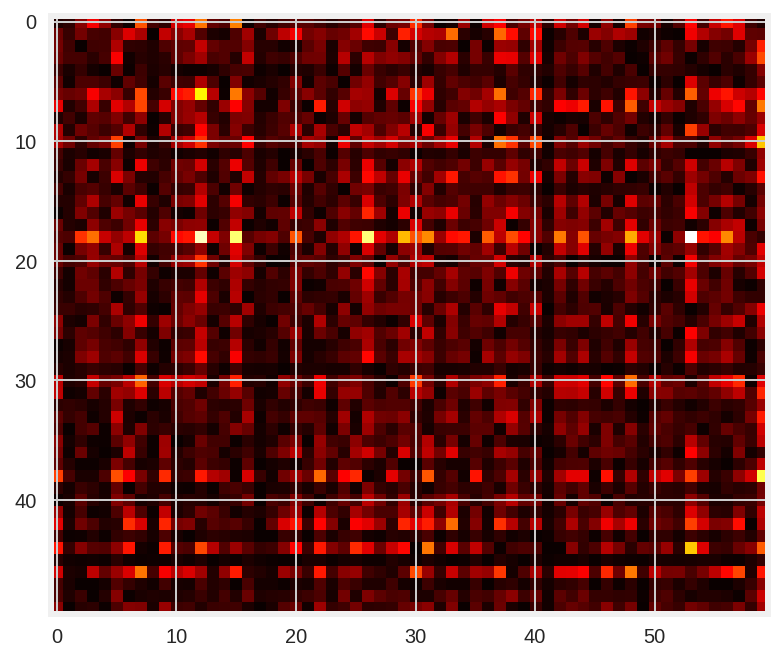

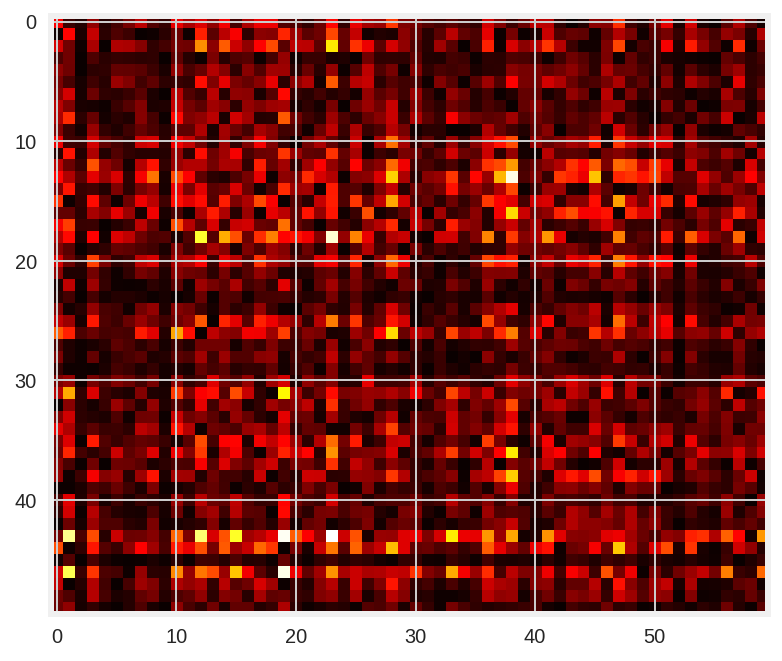

In [0]:
plt.imshow(R_true, cmap='hot')
plt.imshow(evaluate(tf.math.abs(R_true)), cmap='hot')
plt.show()
R_est = evaluate(rv_qR.mean())
plt.imshow(evaluate(tf.math.abs(R_est)), cmap='hot')
plt.show()

## Conclusion

Probabilistic Matrix Factorization is an extremely useful method for making predictive models that extend over matrices of data, and making predictions for the missing values in those matrices. The code you're seeing above is actually very similar to the winning soluion for the Netflix challenge [[3]](#scrollTo=HaxsCOwVRs4i). Similar to the artificial data we produced, the Netflix Challenge data is also very sparse, and has a lot of features that are not necessarily correlated between users [[4]](#scrollTo=HaxsCOwVRs4i). This solution scales linearly as the number of users increases [[2]](#scrollTo=HaxsCOwVRs4i). Other video streaming platforms have also taken similar approaches with their recommendation systems. 

## References

[1] Fusi, Nicolo, Rishit Sheth, and Huseyn Melih Elibol. ["Probabilistic matrix factorization for automated machine learning."](https://arxiv.org/abs/1705.05355) arXiv preprint arXiv:1705.05355 (2017).

[2] Severinski, Cody, and Ruslan Salakhutdinov. ["Bayesian Probabilistic Matrix Factorization: A User Frequency Analysis."](https://arxiv.org/abs/1407.7840) arXiv preprint arXiv:1407.7840 (2014).

[3] The Netflix Challenge: http://www.cs.toronto.edu/~wuyu/machine_learning_project.pdf

[4] Winning the Netflix Prize: https://sifter.org/~simon/journal/20061211.html